- 개발 환경(OS): Windows 10 Education, 64비트 운영 체제, x64 기반 프로세서
![image.png](attachment:image.png)

## Library version check

In [1]:
!pip install optuna sktime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 44.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 66.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 53.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.2/118.2 kB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 27.9 MB/s eta 0:00:00


In [2]:
import sys
import sktime
import tqdm as tq
import xgboost as xgb
import matplotlib
import optuna
import seaborn as sns
import sklearn as skl
import pandas as pd
import numpy as np
print("-------------------------- Python & library version --------------------------")
print("Python version: {}".format(sys.version))
print("pandas version: {}".format(pd.__version__))
print("numpy version: {}".format(np.__version__))
print("matplotlib version: {}".format(matplotlib.__version__))
print("tqdm version: {}".format(tq.__version__))
print("sktime version: {}".format(sktime.__version__))
print("xgboost version: {}".format(xgb.__version__))
print("seaborn version: {}".format(sns.__version__))
print("scikit-learn version: {}".format(skl.__version__))
print("------------------------------------------------------------------------------")

-------------------------- Python & library version --------------------------
Python version: 3.9.16 (main, Dec  7 2022, 01:11:51) 
[GCC 9.4.0]
pandas version: 1.5.0
numpy version: 1.23.4
matplotlib version: 3.6.1
tqdm version: 4.64.1
sktime version: 0.21.0
xgboost version: 1.6.2
seaborn version: 0.12.0
scikit-learn version: 1.1.2
------------------------------------------------------------------------------


## 0. load the libararies

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings(action='ignore')
pd.set_option('display.max_columns', 30)

## 1. preprocessing the data

#####  - time series를 일반 regression 문제로 변환하기 위해 시간 관련 변수 추가(월 / 주 / 요일)
#####  - 전력소비량의 건물별 요일별 시간대별 평균 / 건물별 시간대별 평균 / 건물별 시간대별 표준편차 변수 추가
###### 건물별 요일별 시간대별 표준편차 / 건물별 평균 등 여러 통계량 생성 후 몇개 건물에 테스트, 최종적으로 성능 향상에 도움이 된 위 3개 변수만 추가
#####  - 공휴일 변수 추가
#####  - 시간(hour)는 cyclical encoding하여 변수 추가(sin time & cos time) 후 삭제
#####  - CDH(Cooling Degree Hour) & THI(불쾌지수) 변수 추가
##### - 건물별 모델 생성 시 무의미한 태양광 발전 시설 / 냉방시설 변수 삭제

In [4]:
def interpolate_(train_df):
    # https://dacon.io/competitions/official/235736/codeshare/2844?page=1&dtype=recent
    # 에서 제안된 방법으로
    __methods = {
        'precipitation': 'quadratic',
        'windspeed':'quadratic',
        'humidity':'quadratic',
        # 'insolation': 'pad'
    }

    for col, method in __methods.items():
        train_df[col] = train_df[col].interpolate(method=method)
        if method == 'quadratic':
            train_df[col] = train_df[col].interpolate(method='linear')

In [5]:
path = ''
train = pd.read_csv(path+'train_process.csv')

train = train[['datetime', 'num', 'target', 'temperature', 'precipitation', 'windspeed', 'humidity', 'floor_area', 'cooling_area', 'solar', 'ESS', 'PCS']]

## 변수들을 영문명으로 변경
# cols = ['num', 'date_time', 'power', 'temp', 'wind','hum' ,'prec', 'sun', 'non_elec', 'solar']
# train.columns = cols

interpolate_(train)
train = train.fillna(method='bfill')

# 시간 관련 변수들 생성
date = pd.to_datetime(train.datetime)
train['date'] = str(date)
train['hour'] = date.dt.hour
train['day'] = date.dt.weekday
train['month'] = date.dt.month
train['week'] = date.dt.weekofyear
train['dow'] = date.dt.weekday

#######################################
## 건물별, 요일별, 시간별 발전량 평균 넣어주기
#######################################
power_mean = pd.pivot_table(train, values = 'target', index = ['num', 'hour', 'day'], aggfunc = np.mean).reset_index()
tqdm.pandas()
train['day_hour_mean'] = train.progress_apply(lambda x : power_mean.loc[(power_mean.num == x['num']) & (power_mean.hour == x['hour']) & (power_mean.day == x['day']) ,'target'].values[0], axis = 1)

#######################################
## 건물별 시간별 발전량 평균 넣어주기
#######################################
power_hour_mean = pd.pivot_table(train, values = 'target', index = ['num', 'hour'], aggfunc = np.mean).reset_index()
tqdm.pandas()
train['hour_mean'] = train.progress_apply(lambda x : power_hour_mean.loc[(power_hour_mean.num == x['num']) & (power_hour_mean.hour == x['hour']) ,'target'].values[0], axis = 1)

#######################################
## 건물별 시간별 발전량 표준편차 넣어주기
#######################################
power_hour_std = pd.pivot_table(train, values = 'target', index = ['num', 'hour'], aggfunc = np.std).reset_index()
tqdm.pandas()
train['hour_std'] = train.progress_apply(lambda x : power_hour_std.loc[(power_hour_std.num == x['num']) & (power_hour_std.hour == x['hour']) ,'target'].values[0], axis = 1)

### 공휴일 변수 추가
special_days = ['2020-01-01', '2020-06-06', '2020-08-15', '2020-08-17', '2020-01-24', '2020-01-25', '2020-01-26', '2020-01-27', '2020-03-01', '2020-04-15', '2020-04-30', '2020-05-05', '2020-09-30', '2020-10-01', '2020-10-02', '2020-10-03', '2020-10-09', '2020-12-25',
                '2021-01-01', '2021-02-11', '2021-02-12', '2021-02-13', '2021-03-01', '2021-05-05', '2021-05-19', '2021-06-06', '2021-08-15', '2021-09-20', '2021-09-21', '2021-09-22', '2021-10-03', '2021-10-09', '2021-12-25',
                '2022-01-01', '2022-01-31', '2022-02-01', '2022-02-02', '2022-03-01', '2022-05-05', '2022-05-08', '2022-06-06', '2022-08-15', '2022-09-09', '2022-09-10', '2022-09-11', '2022-09-12', '2022-10-03', '2022-10-09',  '2022-10-10', '2022-12-25']
train['holiday'] = train['dow'].isin([5,6]).astype(int)
train.loc[train.date.isin(special_days), 'holiday'] = 1

## https://dacon.io/competitions/official/235680/codeshare/2366?page=1&dtype=recent
train['sin_time'] = np.sin(2*np.pi*train.hour/24)
train['cos_time'] = np.cos(2*np.pi*train.hour/24)

# https://dacon.io/competitions/official/235736/codeshare/2743?page=1&dtype=recent
train['THI'] = 9/5*train['temperature'] - 0.55*(1-train['humidity']/100)*(9/5*train['humidity']-26)+32

def CDH(xs):
    ys = []
    for i in range(len(xs)):
        if i < 11:
            ys.append(np.sum(xs[:(i+1)]-26))
        else:
            ys.append(np.sum(xs[(i-11):(i+1)]-26))
    return np.array(ys)

cdhs = np.array([])
for num in range(1,101,1):
    temp = train[train['num'] == num]
    cdh = CDH(temp['temperature'].values)
    cdhs = np.concatenate([cdhs, cdh])
train['CDH'] = cdhs

train.drop(['date', 'dow'], axis = 1, inplace = True)
train.head()

100%|██████████| 204000/204000 [01:14<00:00, 2750.11it/s]


,datetime,num,target,temperature,precipitation,windspeed,humidity,floor_area,cooling_area,solar,ESS,PCS,hour,day,month,week,day_hour_mean,hour_mean,hour_std,holiday,sin_time,cos_time,THI,CDH
0,20220601 00,1,1085.28,18.6,0.0,0.9,42.0,110634.0,39570.0,0.0,0.0,0,0,2,6,22,1774.744615,1706.318118,446.882767,0,0.000000,1.000000,49.6576,-7.4
1,20220601 01,1,1047.36,18.0,0.0,1.1,45.0,110634.0,39570.0,0.0,0.0,0,1,2,6,22,1687.347692,1622.620235,439.662704,0,0.258819,0.965926,47.7625,-15.4
2,20220601 02,1,974.88,17.7,0.0,1.5,45.0,110634.0,39570.0,0.0,0.0,0,2,2,6,22,1571.483077,1506.971294,412.071906,0,0.500000,0.866025,47.2225,-23.7
3,20220601 03,1,953.76,16.7,0.0,1.4,48.0,110634.0,39570.0,0.0,0.0,0,3,2,6,22,1522.153846,1437.365647,391.205981,0,0.707107,0.707107,44.7856,-33.0
4,20220601 04,1,986.40,18.4,0.0,2.8,43.0,110634.0,39570.0,0.0,0.0,0,4,2,6,22,1506.793846,1447.321412,381.099697,0,0.866025,0.500000,49.0061,-40.6


In [6]:
# train set과 동일한 전처리 과정
test = pd.read_csv(path+'test_process.csv')
test = test[['datetime', 'num', 'temperature', 'precipitation', 'windspeed', 'humidity', 'floor_area', 'cooling_area', 'solar', 'ESS', 'PCS']]
date = pd.to_datetime(test.datetime)
test['hour'] = date.dt.hour
test['day'] = date.dt.weekday
test['month'] = date.dt.month
test['week'] = date.dt.weekofyear
test['sin_time'] = np.sin(2*np.pi*test.hour/24)
test['cos_time'] = np.cos(2*np.pi*test.hour/24)
test['dow'] = date.dt.weekday
test['holiday'] = test['dow'].isin([5,6]).astype(int)
# test.loc[('2020-08-17'<=test.date_time)&(test.date_time<'2020-08-18'), 'holiday'] = 1

## 건물별 일별 시간별 발전량 평균
tqdm.pandas()
test['day_hour_mean'] = test.progress_apply(lambda x : power_mean.loc[(power_mean.num == x['num']) & (power_mean.day == x['day']) & (power_mean.hour == x['hour']) ,'target'].values[0], axis = 1)

## 건물별 시간별 발전량 평균 넣어주기
tqdm.pandas()
test['hour_mean'] = test.progress_apply(lambda x : power_hour_mean.loc[(power_hour_mean.num == x['num']) & (power_hour_mean.hour == x['hour']) ,'target'].values[0], axis = 1)

tqdm.pandas()
test['hour_std'] = test.progress_apply(lambda x : power_hour_std.loc[(power_hour_std.num == x['num']) & (power_hour_std.hour == x['hour']) ,'target'].values[0], axis = 1)

# test.drop(['non_elec', 'solar','hour','date_time'], axis = 1, inplace = True)

# # pandas 내 선형보간 method 사용
# for i in range(60):
#     test.iloc[i*168:(i+1)*168, :]  = test.iloc[i*168:(i+1)*168, :].interpolate()


test['THI'] = 9/5*test['temperature'] - 0.55*(1-test['humidity']/100)*(9/5*test['humidity']-26)+32

cdhs = np.array([])
for num in range(1,101,1):
    temp = test[test['num'] == num]
    cdh = CDH(temp['temperature'].values)
    cdhs = np.concatenate([cdhs, cdh])
test['CDH'] = cdhs

test.drop(columns=['dow'], inplace=True)
# test = test[['num','temp', 'wind', 'hum', 'prec', 'sun', 'day', 'month', 'week',
#        'day_hour_mean', 'hour_mean', 'hour_std', 'holiday', 'sin_time',
#        'cos_time', 'THI', 'CDH']]
test.head()

100%|██████████| 16800/16800 [00:06<00:00, 2787.06it/s]


,datetime,num,temperature,precipitation,windspeed,humidity,floor_area,cooling_area,solar,ESS,PCS,hour,day,month,week,sin_time,cos_time,holiday,day_hour_mean,hour_mean,hour_std,THI,CDH
0,20220825 00,1,23.5,0.0,2.2,72,110634.0,39570.0,0.0,0.0,0,0,3,8,34,0.000000,1.000000,0,1627.80,1706.318118,446.882767,58.3456,-2.5
1,20220825 01,1,23.0,0.0,0.9,72,110634.0,39570.0,0.0,0.0,0,1,3,8,34,0.258819,0.965926,0,1550.08,1622.620235,439.662704,57.4456,-5.5
2,20220825 02,1,22.7,0.0,1.5,75,110634.0,39570.0,0.0,0.0,0,2,3,8,34,0.500000,0.866025,0,1431.12,1506.971294,412.071906,57.8725,-8.8
3,20220825 03,1,22.1,0.0,1.3,78,110634.0,39570.0,0.0,0.0,0,3,3,8,34,0.707107,0.707107,0,1372.20,1437.365647,391.205981,57.9376,-12.7
4,20220825 04,1,21.8,0.0,1.0,77,110634.0,39570.0,0.0,0.0,0,4,3,8,34,0.866025,0.500000,0,1381.72,1447.321412,381.099697,56.9961,-16.9


In [7]:
# ## save the preprocessed data
# train.to_csv('./data/train_preprocessed.csv')

#### sktime library으로 마지막 일주일을 validation set으로 설정

train data shape
x:(1872, 21), y:(1872,)


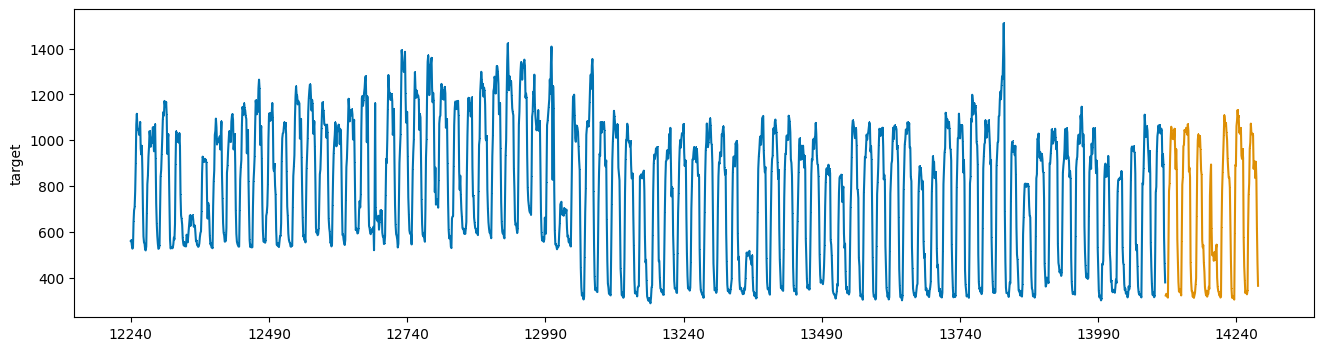

In [8]:
## 7번 건물의 발전량
y = train.loc[train.num == 7, 'target']
x = train.loc[train.num == 7, ].iloc[:, 3:]

y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = y, X = x, test_size = 168) # 24시간*7일 = 168

print('train data shape\nx:{}, y:{}'.format(x_train.shape, y_train.shape))

plot_series(y_train, y_valid, markers=[',' , ','])
plt.show()

## 2. Model : XGBoost

#### 모델은 시계열 데이터에 좋은 성능을 보이는 XGBoost를 선정했습니다.

In [9]:
# Define SMAPE loss function
def SMAPE(true, pred):
    return np.mean((np.abs(true-pred))/(np.abs(true) + np.abs(pred))) * 100

#### 아래와 같이 평가 Metric인 SMAPE는 실제값보다 작게 추정할 때 더 좋지 않습니다.
#### 이는 전력사용량을 높게 예측하는 것보다 작게 예측할 때 실제로 더 큰 문제가 될 수 있음을 반영한 것으로 보입니다.

In [10]:
print("실제값이 100일 때 50으로 underestimate할 때의 SMAPE : {}".format(SMAPE(100, 50)))
print("실제값이 100일 때 150으로 overestimate할 때의 SMAPE : {}".format(SMAPE(100, 150)))

실제값이 100일 때 50으로 underestimate할 때의 SMAPE : 33.33333333333333
실제값이 100일 때 150으로 overestimate할 때의 SMAPE : 20.0


#### 그러나 일반 mse를 objective function으로 훈련할 때 과소추정하는 건물들이 있음을 확인했습니다.
#### 이때문에 SMAPE 점수가 높아진다고 판단, 이를 해결하기 위해 아래와 같이 objective function을 새로 정의했습니다.
#### 새 목적함수는 residual이 0보다 클 때, 즉 실제값보다 낮게 추정할 때 alpha만큼의 가중치를 곱해 반영합니다.

#### XGBoost는 custom objective function으로 훈련하기 위해선 아래와 같이
#### gradient(1차 미분함수) / hessian(2차 미분함수)를 정의해 두 값을 return해주어야 합니다.

In [11]:
#### alpha를 argument로 받는 함수로 실제 objective function을 wrapping하여 alpha값을 쉽게 조정할 수 있도록 작성했습니다.
# custom objective function for forcing model not to underestimate
def weighted_mse(alpha = 1):
    def weighted_mse_fixed(label, pred):
        residual = (label - pred).astype("float")
        grad = np.where(residual>0, -2*alpha*residual, -2*residual)
        hess = np.where(residual>0, 2*alpha, 2.0)
        return grad, hess
    return weighted_mse_fixed

alpha=25

## 3. model tuning

#### 다른 parameter를 고정하지 않고 전체 parameter를 튜닝하고자 하면 매우 오래걸리기 때문에
#### 모델 내 hyperparameter들은 아래와 같이 sklearn의 gridsearchCV를 활용해 튜닝하고,
#### XGBoost의 early stopping 기능으로 n_estimators를 튜닝하고,
#### weighted_mse의 alpha값을 튜닝했습니다.

#### ***참고***
##### gridsearch 코드는 빠른 튜닝을 위해 NIPA서버를 활용해 gpu버전으로 튜닝하여 cpu버전으로 찾은 parameter와는 값이 다릅니다.
###### (gpu와 cpu버전의 bootstrap 과정 등의 차이에 기인하는 것으로 생각됩니다.)
##### 그러므로 gridsearchCV 코드는 제출하되 튜닝된 parameter를 csv로 첨부합니다.
##### 이후 모든 과정은 첨부된 csv에 저장된 paramter를 사용하여 훈련, 예측합니다.  

In [ ]:
from sklearn.model_selection import PredefinedSplit, GridSearchCV
preds = np.array([])


for i in tqdm(np.arange(1, 101)):
    y = train.loc[train.num == i, 'target']
    x = train.loc[train.num == i, ].iloc[:, 3:]
    pred_df = pd.DataFrame()
    for seed in [46]:
        def objective(trial):
            y_train, y_test, x_train, x_test = temporal_train_test_split(y = y, X = x, test_size = 168)

            params = {
            'tree_method':'gpu_hist',  # this parameter means using the GPU when training our model to speedup the training process
            "objective": "weighted_mse(25)",
            'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
            "alpha": trial.suggest_loguniform("alpha", 0.01, 10.0),
            "gamma": trial.suggest_loguniform("lambda", 1e-8, 10.0),
            'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
            'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
            "learning_rate": trial.suggest_loguniform("learning_rate", 0.005, 0.05),
            'n_estimators':trial.suggest_int("n_estimators", 30, 10000),
            'max_depth': trial.suggest_int('max_depth', 5, 17),
            # 'random_state': trial.suggest_categorical('random_state', [2020]),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
            'random_state': seed,
            'gpu_id': 0
            }


            pds = PredefinedSplit(np.append(-np.ones(len(x)-168), np.zeros(168)))
            model = xgb.XGBRegressor(**params)
            model.fit(x_train, y_train)

            pred = model.predict(x_test)

            smape = SMAPE(y_test, pred)
            return smape

        study = optuna.create_study(direction="minimize")
        study.optimize(objective, n_trials=20)

        params=study.best_params
        params['tree_method'] = 'gpu_hist'
        params['random_state'] = seed

        y_train = train.loc[train.num == i, 'target']
        x_train, x_test = train.loc[train.num == i, ].iloc[:, 3:], test.loc[test.num == i, ].iloc[:,1:]
        x_test = x_test[x_train.columns]

        model = XGBRegressor(**params)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        pred_df.loc[:,seed] = y_pred
    pred = pred_df.mean(axis=1)
    preds = np.append(preds, pred)

  0%|          | 0/100 [00:00<?, ?it/s][I 2023-07-25 01:30:11,259] A new study created in memory with name: no-name-6dc9d64a-d1db-4711-be35-8f775bc2a8a9
[I 2023-07-25 01:30:15,281] Trial 0 finished with value: 4.493010729555577 and parameters: {'lambda': 0.7072276992074092, 'alpha': 0.8078152571649455, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.024338665957673818, 'n_estimators': 7386, 'max_depth': 11, 'min_child_weight': 296}. Best is trial 0 with value: 4.493010729555577.
[I 2023-07-25 01:30:21,567] Trial 1 finished with value: 3.06213343875617 and parameters: {'lambda': 1.6078874162293653, 'alpha': 0.04925266475476217, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.00803387634516232, 'n_estimators': 8405, 'max_depth': 6, 'min_child_weight': 165}. Best is trial 1 with value: 3.06213343875617.
[I 2023-07-25 01:30:27,229] Trial 2 finished with value: 5.525741967830291 and parameters: {'lambda': 0.2110532326286871, 'alpha': 5.298941332305156, 'colsample

In [ ]:
submission = pd.read_csv(path + 'sample_submission.csv')
submission['answer'] = preds
submission.to_csv(path + 'xgboost_optuna5.csv', index = False)